In [1]:
import os
import tensorflow.compat.v1 as tf
import numpy as np
import heapq
import cv2
import matplotlib.pyplot as plt
#  FIXME:  need to figure out the optimal way of choosing a neural network. For now this will be harcoded. 
OP_FNAME_PATH = '/data/YOLO-RES-720P/exp/chaweng/models/chaweng-a3d16c61813043a2711ed3f5a646e4eb.hdf5'

#  FIXME: directory for images that are currently used for testing the neural network
IMAGE_DIR = '/config/Testing_Images'

In [2]:
class OP():
    
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.3
    tf.keras.backend.set_session(tf.Session(config=config))
    
    
    def __init__(self, op_fname):
        self.run_imgs = list()
        self.crop = None
        self.op = tf.keras.models.load_model(op_fname)
        self.frames = list()
        self.in_h, self.in_w = self.op.layers[0].input_shape[1:3]

    
    def read_images(self, imgs, H, W, crop=(-1,-1,-1,-1)):
        frames = np.zeros((len(imgs), H, W, 3), dtype='float32')
        f, axarr = plt.subplots(2,1) 
        for i, img in enumerate(imgs):
            frame = cv2.imread(img)
            axarr[0].imshow(frame)
            if crop[0] > 0:
                frame = frame[crop[0]:crop[2],crop[1]:crop[3]]
            frame = cv2.resize(frame, (H, W), interpolation=cv2.INTER_NEAREST)
            axarr[1].imshow(frame)
            frames[i, :] = frame
        frames /= 255.0
        return frames
    
    
    def prepare(self, img_dir, img_name, crop):
        self.run_imgs = list()
        self.run_imgs.append(os.path.join(img_dir, img_name))
        self.crop = [int(x) for x in crop.split(',')]
        in_h, in_w = self.op.layers[0].input_shape[1:3]
        self.frames = self.read_images(self.run_imgs, self.in_h, self.in_w, self.crop) 
      
    
    def run(self):
        output = list()
        scores = self.op.predict(self.frames)
        heapq.heappush(output, (scores[0, 1], self.run_imgs[0].split('/')[-1]))
        return output

In [3]:
def test_operator(Operator):
    '''
    This function passes image paths into the OP class to format the images accordingly and then outputs 
    confidence scores of each image inside of the IMAGE_DIR.
    '''
    #  FIXME: Need to change it to loop through testing folder. For now its good enough.
    selected_imgs = os.listdir(IMAGE_DIR)
    
    # FIXME
    for img in selected_imgs[:]:
        if not img.endswith((".jpeg", ".jpg", ".png")):
            selected_imgs.remove(img)
    
    for img in selected_imgs:
        Operator.prepare(IMAGE_DIR, img, '350,0,720,400') #  FIXME: need to fugure out the croping value
        print(Operator.run())

[(9.46405e-06, '0017.jpeg')]
[(0.013523831, 'b.jpeg')]
[(0.00022431926, 'street_bike.jpeg')]
[(4.5820443e-06, '0123.jpeg')]


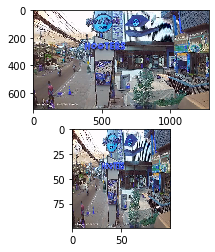

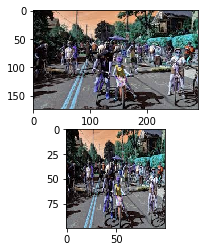

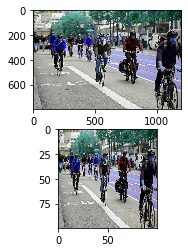

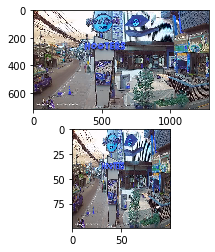

In [4]:
if __name__ == "__main__":
    #  Initializing OP class which loads operator using tensorflow
    Operator = OP(OP_FNAME_PATH)
    
    #  Tests operators accuracy by testing operator accuracy with three different images
    test_operator(Operator)